In [1]:
!pip install transformers
!pip install evaluate
!pip install sacrebleu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 9.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.5.1
    Uninstalling fsspec-2025.5.1:
      Successfully uninstalled fsspec-2025.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidi

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from matplotlib.font_manager import FontProperties
from transformers import MT5ForConditionalGeneration, MT5Tokenizer
import torch
import evaluate

2025-07-22 13:14:37.598084: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753190077.785378      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753190077.838152      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
font_cn = FontProperties(fname="/kaggle/input/font-nomnatong/NomNaTong-Regular.ttf")

paths = {
    'train': '/kaggle/input/translate-nom-vietnam/train.csv',
    'val':   '/kaggle/input/translate-nom-vietnam/val.csv',
    'test':  '/kaggle/input/translate-nom-vietnam/test.csv'
}

model_dir = "/kaggle/input/translate_nom_vietnamese/transformers/default/1"

# EDA

In [4]:
prefix = 'translate Vietnamese_nom to Vietnamese: '

In [5]:
datasets = {name: pd.read_csv(path) for name, path in paths.items()}
for name, path in paths.items():
    datasets[name]['source'] = datasets[name]['source'].replace(prefix, '', regex=True)

## Tập dữ liệu

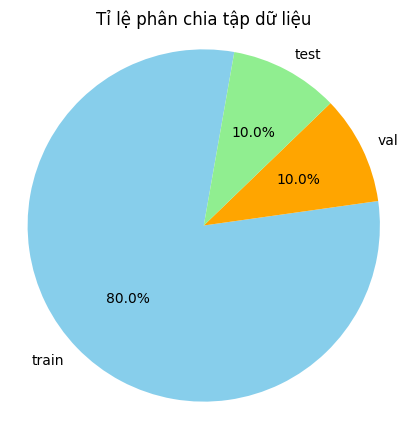

In [6]:
sizes = {split: len(df) for split, df in datasets.items()}

plt.figure(figsize=(5,5))
plt.pie(
    sizes.values(),
    labels=sizes.keys(),
    autopct='%1.1f%%',
    colors=['skyblue', 'orange', 'lightgreen'],
    startangle=80
)
plt.title('Tỉ lệ phân chia tập dữ liệu')
plt.axis('equal')
plt.show()


In [7]:
datasets['train'].head()

,source,target
0,帝御天慶殿執,đế ngự thiên khánh điện chấp
1,車吹隔𠇍吝𨗊拱蹺,xa xôi cách mấy lần đò cũng theo
2,身𠦳鐄底名𦟐紅,thân ngàn vàng để ô danh má hồng
3,車祿金吾衞上将軍大置字車渴車盤車點並爲玉鈐衞大将軍明字並四國姓,xa lộc kim ngô vệ thượng tướng quân đại trí tự...
4,些群朗蕩𬈋之女象固𡗶排達為,ta còn lãng đãng làm chi nữa. tuồng có trời bà...


In [8]:
datasets['train'].tail()

,source,target
47390,𥙩之𢷀䋦孕𦀚衛𡢐,lấy chi rủ mối dựng giềng về sau
47391,𩶪鱩鯱鯁𩹹鮋𫃚絁𬗢𦀎論都𦋦𠓨,cháy trôi hố ngạnh giếc rô. vóc the là lượt rộ...
47392,𩚵共粥𠲝奴隊𩛷油白,cơm cùng cháo đói no đòi bữa
47393,𠰺浪拠法加刑,dạy rằng cứ phép gia hình
47394,沛干颯所打共時沈托,"phải cơn táp thửa đánh, cùng thời đắm thác"


### Những từ phổ biến nhất

In [9]:
def draw_diagram(ax, word_freq, title='Top từ phổ biến', x_font=None):
    words, freqs = zip(*word_freq)
    ax.bar(words, freqs, color='coral', edgecolor='black')
    ax.set_title(title)
    ax.set_xlabel('Từ')
    ax.set_ylabel('Tần suất')
    if x_font:
        ax.set_xticklabels(words, rotation=45, fontproperties=x_font)
    else:
        ax.set_xticklabels(words, rotation=45)
    ax.grid(axis='y', linestyle='--', alpha=0.5)


/tmp/ipykernel_19/1152468442.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(words, rotation=45)
/tmp/ipykernel_19/1152468442.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(words, rotation=45, fontproperties=x_font)


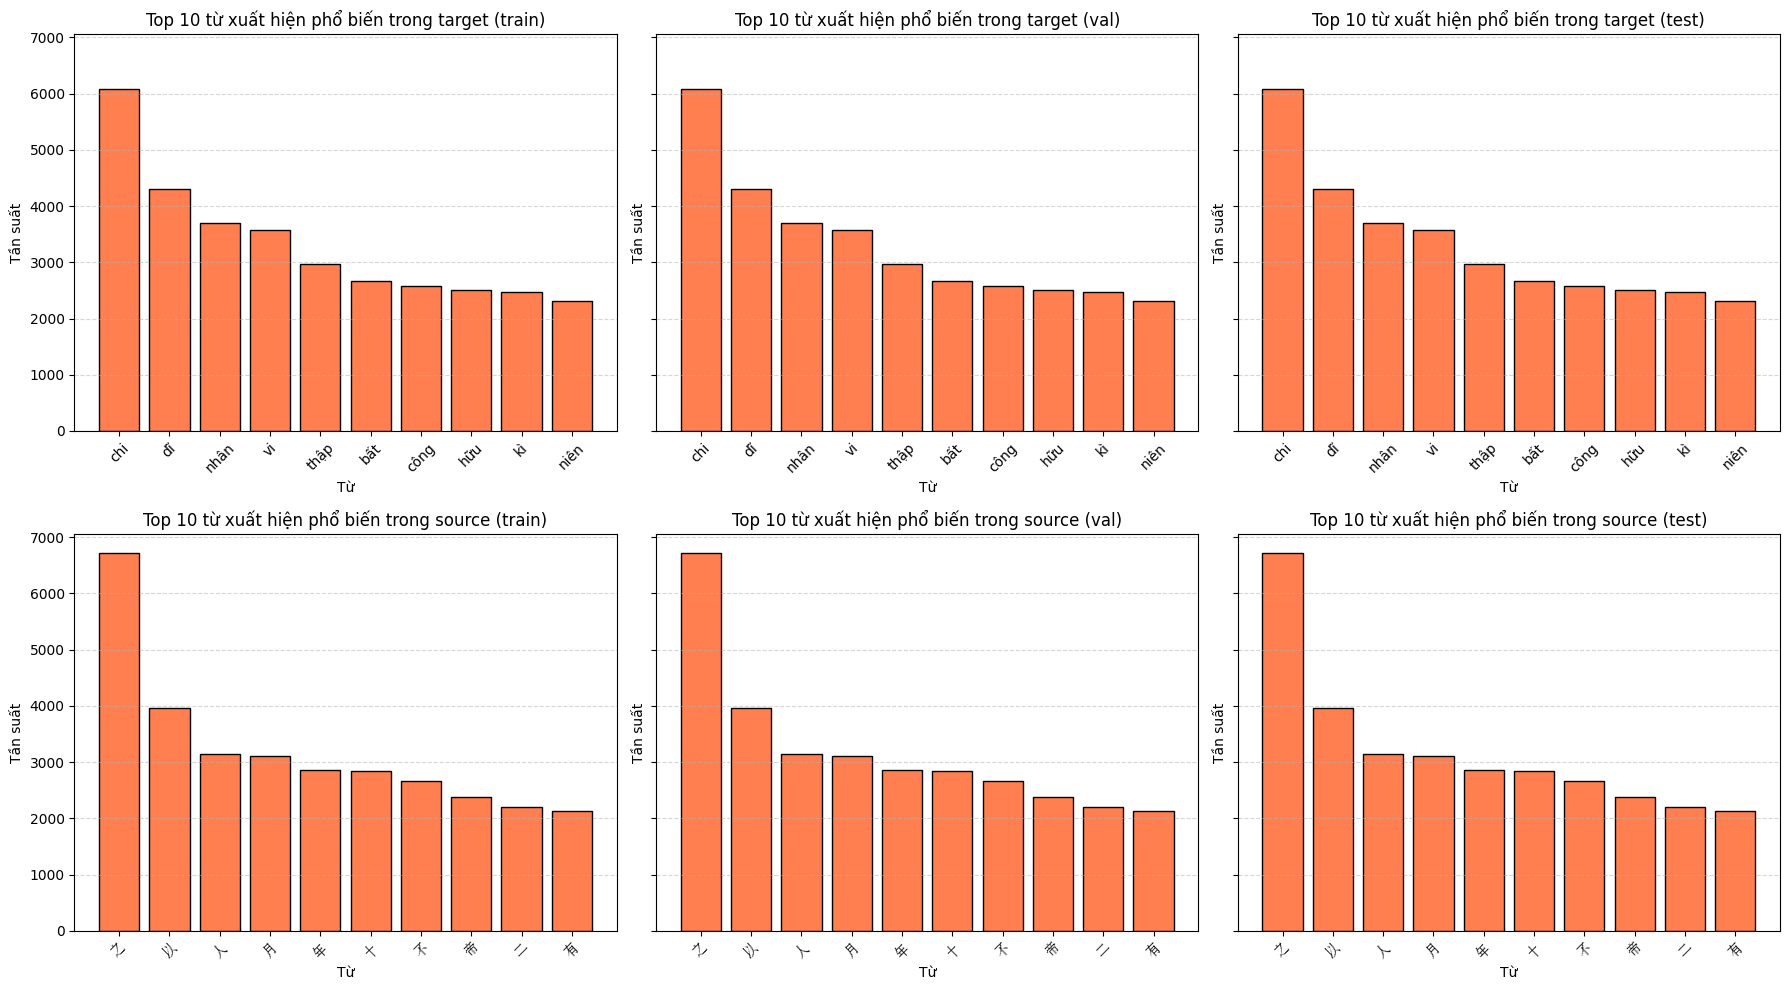

In [10]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharey=True)

for i, split in enumerate(['train', 'val', 'test']):

    st = ' '.join(datasets['train']['target'].to_list()).split()
    draw_diagram(
        ax=axes[0, i],
        word_freq=Counter(st).most_common(10),
        title='Top 10 từ xuất hiện phổ biến trong target ({})'.format(split)
    )

    st = ''.join(datasets['train']['source'].to_list())
    draw_diagram(
        ax=axes[1, i],
        word_freq=Counter(st).most_common(10),
        title='Top 10 từ xuất hiện phổ biến trong source ({})'.format(split),
        x_font=font_cn
    )

plt.tight_layout()
plt.show()

## Biểu đồ tương quan

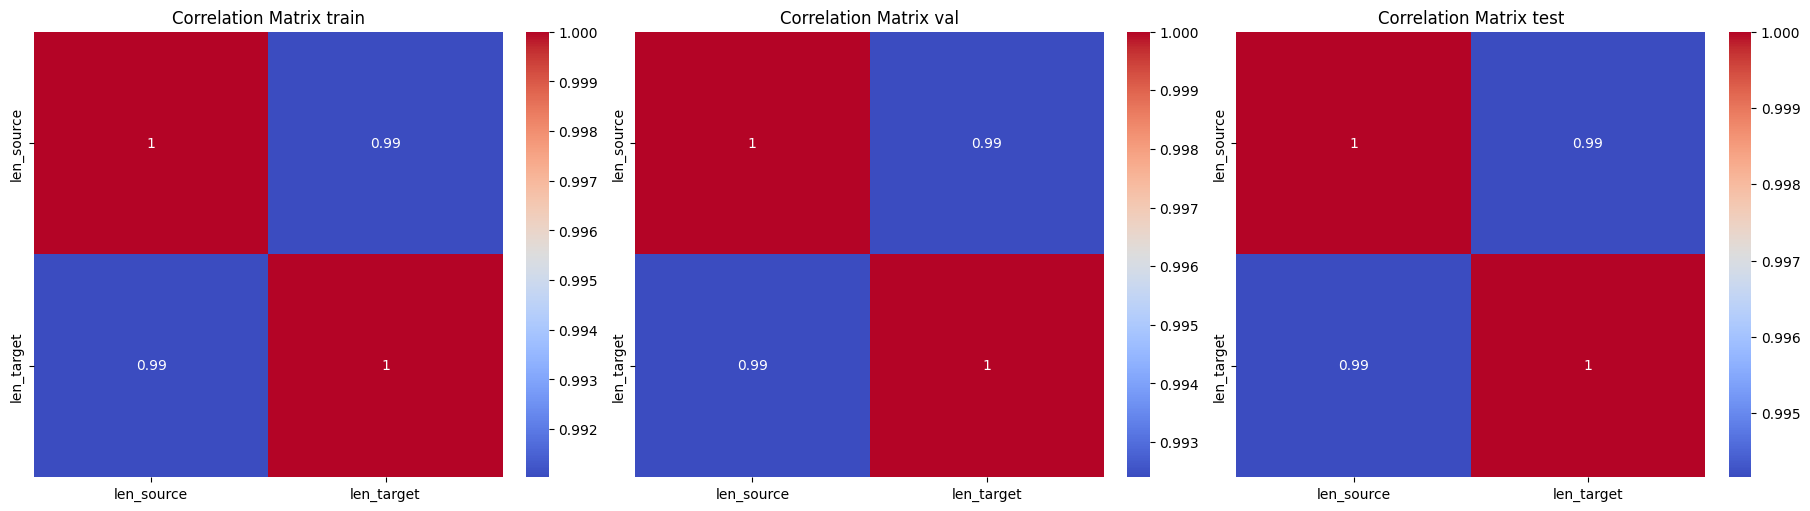

In [11]:
fig, axes = plt.subplots(
    nrows=1, ncols=3,
    figsize=(18, 5),
    constrained_layout=True
)

for i, split in enumerate(['train', 'val', 'test']):
    df = datasets[split]

    df = pd.DataFrame({
        'len_source': df['source'].dropna().str.len(),
        'len_target': df['target'].dropna().str.split().apply(len)
    })

    sns.heatmap(df.corr(), annot=True, cmap='coolwarm', ax=axes[i])
    axes[i].set_title("Correlation Matrix {}".format(split))


plt.show()


## Phân phối dữ liệu của độ dài câu (tokens)

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

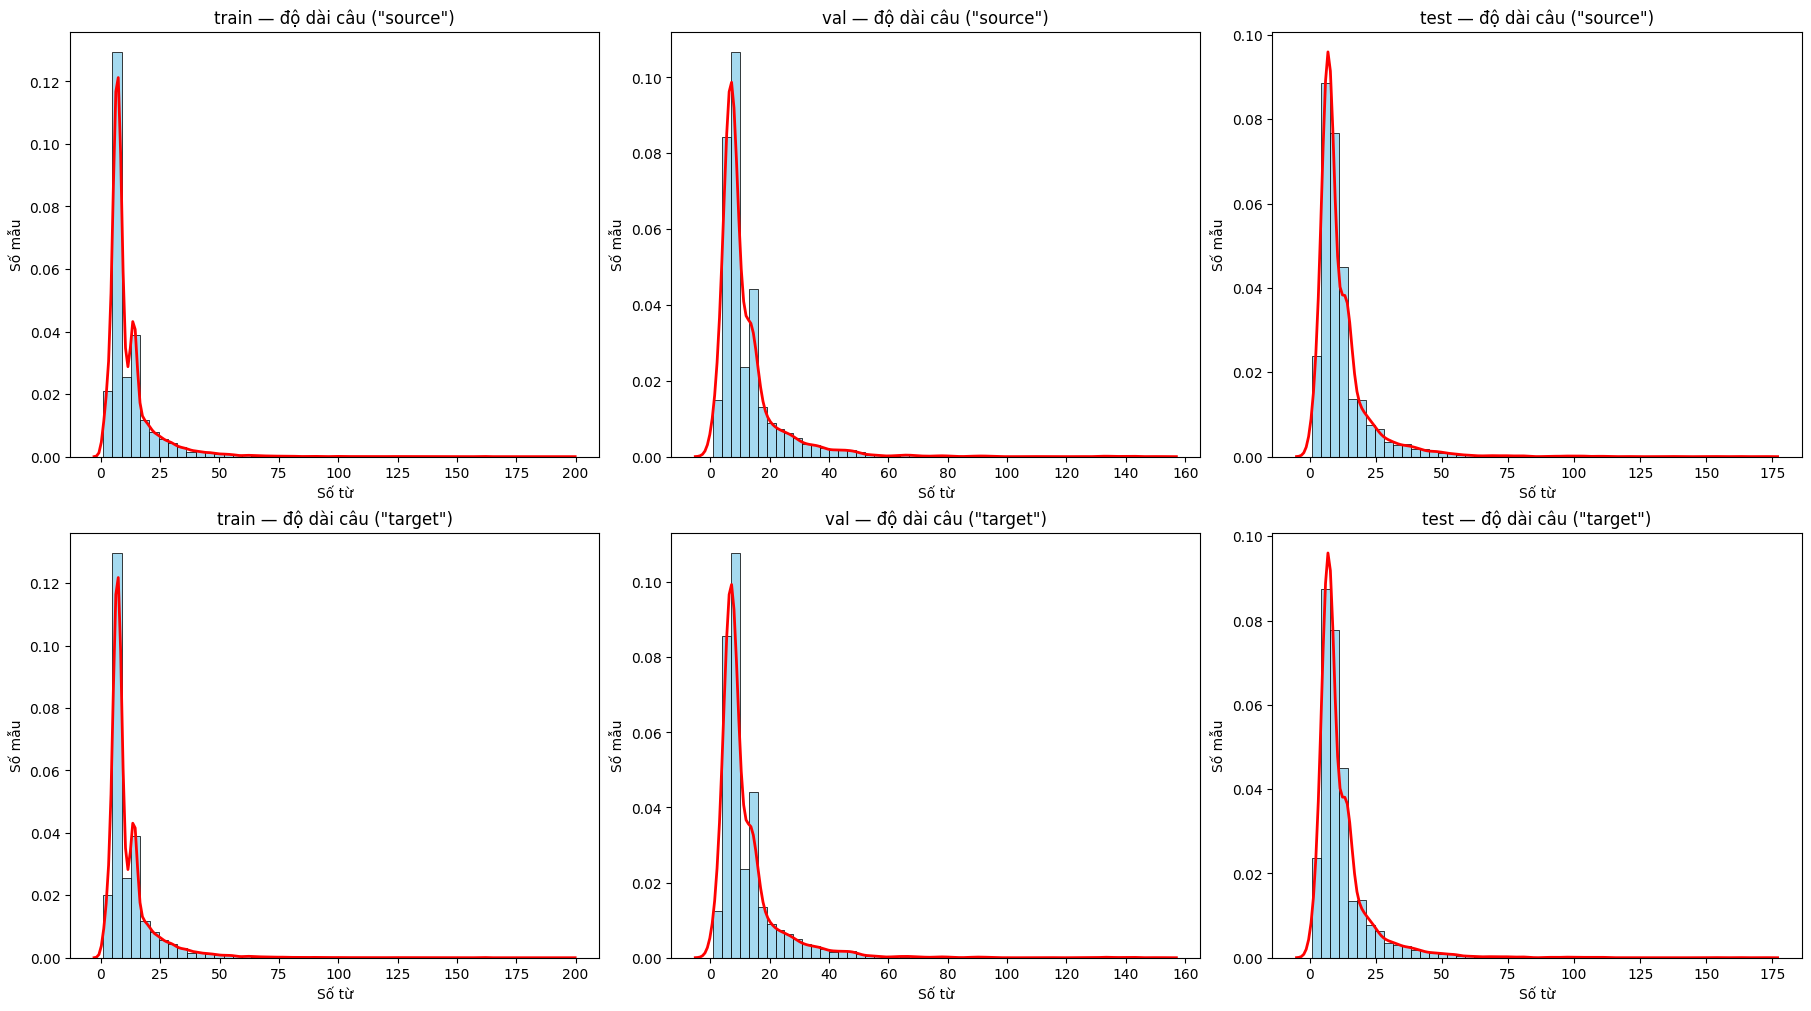

In [12]:
fig, axes = plt.subplots(
    nrows=2, ncols=3,
    figsize=(18, 10),
    constrained_layout=True
)

for j, split in enumerate(['train', 'val', 'test']):
    df = datasets[split]

    lengths = df['source'].dropna().str.len()

    sns.histplot(lengths, bins=50, color='skyblue', edgecolor='black', stat='density', ax=axes[0, j])
    sns.kdeplot(lengths, color='red', linewidth=2, ax=axes[0, j])

    axes[0, j].set_title(f'{split} — độ dài câu ("source")')
    axes[0, j].set_xlabel('Số từ')
    axes[0, j].set_ylabel('Số mẫu')


    lengths = df['target'].dropna().str.split().apply(len)

    sns.histplot(lengths, bins=50, color='skyblue', edgecolor='black', stat='density', ax=axes[1, j])
    sns.kdeplot(lengths, color='red', linewidth=2, ax=axes[1, j])

    axes[1, j].set_title(f'{split} — độ dài câu ("target")')
    axes[1, j].set_xlabel('Số từ')
    axes[1, j].set_ylabel('Số mẫu')

plt.show()


***tương đồng (source,  target) => kiểu dịch 1-1. phần phổi giữa các tập không đều***

In [13]:
stats = {}
for split, df in datasets.items():
    for col in ['source', 'target']:
        if col == 'target':
            lengths = df[col].dropna().str.split().apply(len)
        else:
            lengths = df[col].dropna().str.len()

        stats[(split, col)] = [
            len(lengths),             # count
            lengths.nunique(),        # unique
            lengths.mean(),           # mean
            lengths.std(),            # std
            lengths.min(),            # min
            lengths.quantile(0.05),   # 5%
            lengths.quantile(0.25),   # 25%
            lengths.quantile(0.50),   # 50%
            lengths.quantile(0.75),   # 75%
            lengths.quantile(0.95),   # 95%
            lengths.max()             # max
        ]

index = ['count_len', 'unique_len', 'mean', 'std', 'min', '5%', '25%', '50%', '75%', '95%', 'max']
columns = pd.MultiIndex.from_tuples(stats.keys(), names=('split', 'column'))
df_stats = pd.DataFrame(list(stats.values()), index=columns, columns=index).T

print(df_stats.to_markdown())

|            |   ('train', 'source') |   ('train', 'target') |   ('val', 'source') |   ('val', 'target') |   ('test', 'source') |   ('test', 'target') |
|:-----------|----------------------:|----------------------:|--------------------:|--------------------:|---------------------:|---------------------:|
| count_len  |            47395      |            47395      |           5924      |           5924      |            5925      |            5925      |
| unique_len |              139      |              136      |             93      |             93      |              93      |              92      |
| mean       |               11.8116 |               11.899  |             11.9191 |             11.9828 |              12.0846 |              12.1408 |
| std        |               11.0011 |               11.0699 |             11.4257 |             11.4189 |              11.2871 |              11.3278 |
| min        |                1      |                1      |              1     

***có chữa những câu dài nhưng trong đó chỉ có 95% dữ liệu <= độ dài là 31 => có sự tồn tại của outliers. (nên loại bỏ)***

## Mô tả thông tin của tập dữ liệu

### 1. Tập Train

In [14]:
df = pd.DataFrame({
    "source": datasets['train']['source'].describe(),
    "target": datasets['train']['target'].describe()
})

dupes = datasets['train'].duplicated(subset=['source','target']).sum()
print(f"Số cặp source-target trùng nhau: {dupes}")

df

Số cặp source-target trùng nhau: 0


,source,target
count,47395,47395
unique,46895,44141
top,調󰠲𦖻󱩇頭𧙜𦇒連倍𠳨症之𣈜󰅹,gái tơ mà đã ngứa nghề sớm sao
freq,4,5


***cho thấy 1 câu nhưng nhiều nghĩa***

### 2. Tập val

In [15]:
df = pd.DataFrame({
    "source": datasets['val']['source'].describe(),
    "target": datasets['val']['target'].describe()
})

dupes = datasets['val'].duplicated(subset=['source','target']).sum()
print(f"Số cặp source-target trùng nhau: {dupes}")

df

Số cặp source-target trùng nhau: 0


,source,target
count,5924,5924
unique,5914,5866
top,自󰳅𨖅東南𡴯𡑩,canh khuya thân gái dặm trường
freq,2,3


### 3. Tập test

In [16]:
df = pd.DataFrame({
    "source": datasets['test']['source'].describe(),
    "target": datasets['test']['target'].describe()
})

dupes = datasets['test'].duplicated(subset=['source','target']).sum()
print(f"Số cặp source-target trùng nhau: {dupes}")

df

Số cặp source-target trùng nhau: 0


,source,target
count,5925,5925
unique,5916,5875
top,強吹珠啫絲紆強商,sở khanh đã rẽ dây cương lối nào
freq,2,3


# Evaluation model

In [17]:
df_test = pd.read_csv(paths['test'])

In [18]:
tokenizer = MT5Tokenizer.from_pretrained(model_dir)
model = MT5ForConditionalGeneration.from_pretrained(model_dir, torch_dtype=torch.float32)
model.eval()

MT5ForConditionalGeneration(
  (shared): Embedding(250112, 512)
  (encoder): MT5Stack(
    (embed_tokens): Embedding(250112, 512)
    (block): ModuleList(
      (0): MT5Block(
        (layer): ModuleList(
          (0): MT5LayerSelfAttention(
            (SelfAttention): MT5Attention(
              (q): Linear(in_features=512, out_features=384, bias=False)
              (k): Linear(in_features=512, out_features=384, bias=False)
              (v): Linear(in_features=512, out_features=384, bias=False)
              (o): Linear(in_features=384, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 6)
            )
            (layer_norm): MT5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): MT5LayerFF(
            (DenseReluDense): MT5DenseGatedActDense(
              (wi_0): Linear(in_features=512, out_features=1024, bias=False)
              (wi_1): Linear(in_features=512, out_features=1024, bias=False)
          

In [19]:
model.config

MT5Config {
  "architectures": [
    "MT5ForConditionalGeneration"
  ],
  "classifier_dropout": 0.0,
  "d_ff": 1024,
  "d_kv": 64,
  "d_model": 512,
  "decoder_start_token_id": 0,
  "dense_act_fn": "gelu_new",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "gated-gelu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": true,
  "layer_norm_epsilon": 1e-06,
  "model_type": "mt5",
  "num_decoder_layers": 8,
  "num_heads": 6,
  "num_layers": 8,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "tie_word_embeddings": false,
  "tokenizer_class": "T5Tokenizer",
  "torch_dtype": "float32",
  "transformers_version": "4.52.4",
  "use_cache": true,
  "vocab_size": 250112
}

## Parameter Counts

In [20]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Tổng số tham số: {total_params:,}")
print(f"Số tham số có thể huấn luyện (requires_grad=True): {trainable_params:,}")
print(f"Số tham số cố định (frozen): {total_params - trainable_params:,}")

Tổng số tham số: 300,176,768
Số tham số có thể huấn luyện (requires_grad=True): 300,176,768
Số tham số cố định (frozen): 0


In [21]:
def generate_translation_batch(texts, tokenizer, model, max_input_len=128, max_output_len=128, batch_size=32):
    all_outputs = []

    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True, max_length=max_input_len)
        input_ids = inputs.input_ids.to(model.device)
        attention_mask = inputs.attention_mask.to(model.device)

        with torch.no_grad():
            outputs = model.generate(
                input_ids=input_ids,
                attention_mask=attention_mask,
                max_length=max_output_len,
                num_beams=4,
                early_stopping=True
            )

        decoded = tokenizer.batch_decode(outputs, skip_special_tokens=True)
        all_outputs.extend(decoded)

    return all_outputs


In [22]:
test_subset = df_test.iloc[:].copy()
test_texts = test_subset["source"].tolist()

outputs = generate_translation_batch(test_texts, tokenizer, model, batch_size=16)

test_subset["predicted_output"] = outputs
test_subset[["source", "predicted_output", "target"]].head()


,source,predicted_output,target
0,translate Vietnamese_nom to Vietnamese: 上皇曰家奴雖...,"thượng hoàng viết gia nô tuy hữu vi lạp, bất đ...",thượng hoàng viết gia nô tuy hữu vi lao bất đắ...
1,translate Vietnamese_nom to Vietnamese: 𣈘冬長銅壼咱説,đêm đông trường đồng hồ thính thốt,đêm đông trường đồng hồ thánh thót
2,translate Vietnamese_nom to Vietnamese: 碎它別󰘚別𠸜冷冷,tôi đà biết mặt biết tên lành lành,tôi đà biết mặt biết tên rành rành
3,translate Vietnamese_nom to Vietnamese: 𡭧之哏咘󰜋𠄩,chút chi cắn bó một hai,chút chi gắn bó một hai
4,translate Vietnamese_nom to Vietnamese: 吨嗃外󰘂劔之燕英,đồn kêu ngoài cửa kém chi yến anh,xôn xao ngoài cửa kém gì yến anh


In [23]:
bleu = evaluate.load("sacrebleu")

references = [[ref] for ref in test_subset["target"].tolist()]  # List of list
predictions = test_subset["predicted_output"].tolist()

results = bleu.compute(predictions=predictions, references=references)
print(f"BLEU score: {results['score']:.2f}")

BLEU score: 69.25
